# Recurrent Neural Networks

In this lab we will experiment with recurrent neural networks. We will build a text generation model that predicts a word given the previous words, and hence will allow us to generate a sentence. This can easily be extended to generating a sentence description for a given input image. RNNs are a useful type of model for predicting sequences or handling sequences of things as inputs. In this lab we will use again Pytorch's nn library.

We will also be using the COCO dataset which includes images + textual descriptions (captions) + other annotations. We can browse the dataset here: http://cocodataset.org/#home

First, let's import libraries and make sure we have everything properly installed.

In [15]:
!pip install tqdm
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
import torch, json, string
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
from nltk.tokenize import word_tokenize

In [17]:
!nvidia-smi

Sat Nov  4 21:19:36 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:0A:00.0     Off |                  N/A |
| 23%   30C    P8    15W / 250W |   2478MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 1. Loading and Preprocessing the Text
Pytorch comes with a Dataset class for the COCO dataset but I will write my own class here. This class does two important things: 

1. Building a __vocabulary__ with the most __frequent words__,
2. Building __utilities__ to convert a __sentence into a list of word ids, and back__. 

We are not going to be using the images for the purposes of the lab but you will use them in the assignment questions.

In [18]:
path = "/data/datasets/mscoco_14/annotations/"

In [19]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tqdm

class CocoCaptions(data.Dataset):
    
    # Load annotations in the initialization of the object.
    def __init__(self, captionsFile, vocabulary = None):
        self.data = json.load(open(captionsFile))
        self.imageIds = self.data['images']
        self.annotations = self.data['annotations']
        
        # Build a vocabulary if not provided.
        if not vocabulary:
            self.build_vocabulary()
        else:
            self.vocabulary = vocabulary
        
        
    # Build a vocabulary using the top 5000 words.
    def build_vocabulary(self, vocabularySize = 5000):
        # Count words, this will take a while.
        word_counter = dict()
        for annotation in tqdm(self.annotations, desc = 'Building vocabulary'):
            words = word_tokenize(annotation['caption'].lower())
            for word in words:
                word_counter[word] = word_counter.get(word, 0) + 1
                
        # Sort the words and find keep only the most frequent words.
        sorted_words = sorted(list(word_counter.items()), 
                              key = lambda x: -x[1])
        most_frequent_words = [w for (w, c) in sorted_words[:vocabularySize]]
        word2id = {w: (index + 1) for (index, w) in enumerate(most_frequent_words)}
        
        # Add a special characters for START, END sentence, and UNKnown words.
        word2id['[END]'] = 0
        word2id['[START]'] = len(word2id)
        word2id['UNK'] = len(word2id)
        id2word = {index: w for (w, index) in word2id.items()}
        self.vocabulary = {'word2id': word2id, 'id2word': id2word}
    
    # Transform a caption into a list of word ids.
    def caption2ids(self, caption):
        word2id = self.vocabulary['word2id']
        caption_ids = [word2id.get(w, word2id['UNK']) for w in word_tokenize(caption.lower())]
        caption_ids.insert(0, word2id['[START]'])
        caption_ids.append(word2id['[END]'])
        return torch.LongTensor(caption_ids)
    
    # Transform a list of word ids into a caption.
    def ids2caption(self, caption_ids):
        id2word = self.vocabulary['id2word']
        #return string.join([id2word[w] for w in caption_ids], " ")
        return " ".join([id2word[w] for w in caption_ids])
    
    # Return imgId, and a random caption for that image.
    def __getitem__(self, index):
        annotation = self.annotations[index]
        return annotation['image_id'], self.caption2ids(annotation['caption'])
    
    # Return the number of elements of the dataset.
    def __len__(self):
        return len(self.annotations)
    
# Let's test the data class.
trainData = CocoCaptions(path+'captions_train2014.json')
print('Number of training examples: ', len(trainData))

# It would be a mistake to build a vocabulary using the validation set so we reuse.
valData = CocoCaptions(path+'captions_val2014.json', vocabulary = trainData.vocabulary)
print('Number of validation examples: ', len(valData))

# Print a sample from the training data.
imgId, caption = trainData[0]
print('imgId', imgId)
print('caption', caption.tolist())
print('captionString', trainData.ids2caption(caption))

Building vocabulary: 100%|██████████| 414113/414113 [00:43<00:00, 9576.16it/s]


Number of training examples:  414113
Number of validation examples:  202654
imgId 318556
caption [5001, 1, 141, 512, 8, 668, 415, 277, 57, 0]
captionString [START] a very clean and well decorated empty bathroom [END]


## 2. Making a Data Loader that can Handle Sequences.

Handling sequences is special when processing batches of inputs because each sequence can have a different length. This makes batching complicated, and different libraries have different ways of handling this which might be easier or harder to deal with. Here we are padding the sequences to the maximum sequence length in a given batch. Additionally pytorch has nice utility functions that require sorting the sequences in a batch from longest to shortest.

In [20]:
# The batch builder will pack all sequences of different length into a single tensor by 
# padding shorter sequences with a padding token.
def customBatchBuilder(samples):
    imgIds, captionSeqs = zip(*samples)
    
    # Sort sequences based on length.
    seqLengths = [len(seq) for seq in captionSeqs]
    maxSeqLength = max(seqLengths)
    sorted_list = sorted(zip(list(imgIds), captionSeqs, seqLengths), key = lambda x: -x[2])
    imgIds, captionSeqs, seqLengths = zip(*sorted_list)
    
    # Create tensor with padded sequences.
    paddedSeqs = torch.LongTensor(len(imgIds), maxSeqLength)
    paddedSeqs.fill_(0)
    for (i, seq) in enumerate(captionSeqs):
        paddedSeqs[i, :len(seq)] = seq
    return imgIds, paddedSeqs.t(), seqLengths

# Data loaders in pytorch can use a custom batch builder, which we are using here.
trainLoader = data.DataLoader(trainData, batch_size = 128, 
                              shuffle = True, num_workers = 0,
                              collate_fn = customBatchBuilder)
valLoader = data.DataLoader(valData, batch_size = 128, 
                            shuffle = False, num_workers = 0,
                            collate_fn = customBatchBuilder)

# Now let's try using the data loader.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
print('imgIds', imgIds)
print('paddedSequences', paddedSeqs.size())
print('seqLengths', seqLengths)

imgIds (161244, 281054, 577283, 11422, 350733, 397500, 142985, 96728, 4642, 161383, 335525, 332204, 293385, 161006, 62387, 491833, 232049, 265889, 71339, 270275, 281846, 563692, 266600, 468341, 533424, 518966, 258856, 376009, 436455, 186205, 467050, 58046, 107758, 410441, 563771, 97858, 522952, 127632, 421995, 391646, 463108, 62581, 297441, 276545, 67565, 482446, 129439, 397942, 361059, 319682, 284940, 107586, 452465, 88621, 283730, 198068, 462519, 343799, 57169, 163478, 576088, 160757, 213669, 124804, 397950, 330901, 288372, 398941, 413312, 282934, 176873, 135545, 475947, 247849, 416973, 451353, 516582, 240199, 424709, 28006, 227828, 500789, 577586, 461443, 305103, 470049, 266697, 89012, 427915, 171281, 24912, 515924, 97724, 565165, 154656, 272194, 40165, 183342, 143736, 22256, 166254, 295642, 419125, 569433, 27524, 559331, 236260, 131084, 379044, 31391, 437908, 465853, 486240, 326793, 188973, 227840, 532482, 265225, 392153, 195390, 288586, 398305, 123389, 41319, 196985, 268718, 31502



## 3. Building our model using a Recurrent Neural Network.
We will build a model that predicts the next word based on the previous word using a recurrent neural network. Additionally we will be using an Embedding layer which will assign a unique vector to each word. The network will be trained with a softmax + negative log likelihood loss. Similar to classification we will be trying to optimize for the correct word at each time-step.

In [21]:
# By now, we should know that pytorch has a functional implementation (as opposed to class version)
# of many common layers, which is especially useful for layers that do not have any parameters.
# e.g. relu, sigmoid, softmax, etc.
import torch.nn.functional as F

class TextGeneratorModel(nn.Module):
    '''
    The model has three layers: 
       1. An Embedding layer that turns a sequence of word ids into 
          a sequence of vectors of fixed size: embeddingSize.
       2. An RNN layer that turns the sequence of embedding vectors into 
          a sequence of hiddenStates.
       3. A classification layer that turns a sequence of hidden states into a 
          sequence of softmax outputs.
    '''
    def __init__(self, vocabularySize):
        super(TextGeneratorModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedder = nn.Embedding(vocabularySize, 300)
        self.rnn = nn.RNN(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize

    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, paddedSeqs, initialHiddenState):
        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        
        # Pass the sequence of word embeddings to the RNN.
        rnnOutput, finalHiddenState = self.rnn(embeddingVectors, initialHiddenState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        flatSeqOutput = rnnOutput.view(-1, 512)
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
initialHiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
predictions, _ = model(torch.autograd.Variable(paddedSeqs), initialHiddenState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', paddedSeqs.size()) # 10 input sequences.
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) # 10 output softmax predictions over our vocabularySize outputs.

Here are input and output size tensor sizes:
inputs torch.Size([28, 128])
outputs torch.Size([28, 128, 5003])


## 3. Sampling a New Sentence from the Model.

The code below uses the RNN network as an RNN cell where we only pass one single input word, and a hidden state vector. Then we keep passing the previously predicted word, and previously predicted hidden state to predict the next word. Since the given model is not trained, it will just output a random sequence of words for now. Ideally, the trained model should also learn when to [END] a sentence.

In [40]:
def sample_sentence(model, use_cuda = False):
    counter = 0
    limit = 200
    words = list()

    # Setup initial input state, and input word (we use "the").
    previousWord = torch.LongTensor(1, 1).fill_(trainData.vocabulary['word2id']['the'])
    previousHiddenState = torch.autograd.Variable(torch.Tensor(1, 1, 512).zero_())
    if use_cuda: previousHiddenState = previousHiddenState.cuda()

    while True:
        # Predict the next word based on the previous hidden state and previous word.
        inputWord = torch.autograd.Variable(previousWord)
        if use_cuda: inputWord = inputWord.cuda()
        predictions, hiddenState = model(inputWord, previousHiddenState)
        nextWordId = np.random.multinomial(1, F.softmax(predictions.squeeze()).data.cpu().numpy(), 1).argmax()
        words.append(trainData.vocabulary['id2word'][nextWordId])
        
        # DEBUG
#         print(nextWordId)
#         print(type(nextWordId))
#         print(type(int(nextWordId)))
        # DEBUG - end
        
        # Setup the inputs for the next round.
        nextWordId = int(nextWordId) # wants int not int64
        previousWord.fill_(nextWordId) # -------- <
        previousHiddenState = hiddenState

        # Keep adding words until the [END] token is generated.
        if nextWordId == trainData.vocabulary['word2id']['[END]'] or counter > limit:
            break
        counter += 1
    
    words.insert(0, 'the')
    words.insert(0, '[START]')
    #return string.join(words, " ")
    return " ".join(words)

print(sample_sentence(model, use_cuda = False))

[START] the enough collage branch stationary sofas observing unknown skills travelling purchase fishing drinking coconut starring suspended football hammer shaved embracing telling persons baskets elephant grove community mass meatballs buckets wicker flipped instead blades focused container tooth bikers hamburgers touches rubble backpacks drawers ordinary glass sailor divider plane mustache bending crystal comfortably testing throw pulled lots sock kits expanse 5 college always pong cooked o batteries center & grips roof salsa signpost stylized washes bronze coca-cola screens witha fed wagon force airplanes shots celery reflecting doubles parks guy kit fencing ottoman kiwi tending pro aquarium browsing stew nose hairy oil propellor beaks lands three besides coffee intense toward ages elderly source solitary wake caboose disgusting frosted skiier flower between woolly double-decker outhouse marking pineapples several casually slippers rooster upside baggage turns kinds shearing triple 

## 3. Training the Model

Now that data is pre-processed, we can try training the model. An important part is to define our target labels or ground-truth labels. In this text generation model, we want to predict the next word based on the previous word. So we need to provide as the target a shifted version of the input sequence. The code below looks a lot like the code used for training previous models with only small modifications.

In [41]:
import tqdm as tqdmx
from tqdm import tqdm_notebook as tqdm
tqdmx.tqdm.get_lock().locks = []

def train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    return

Now to the actual training call, notice how unlike previous experiments we are using here <b>RMSprop</b> which is a different type of optimizer that is often preferred for recurrent neural networks, although others such as SGD, and ADAM will also work. Additionally we are using <b>nn.NLLLoss</b> for the loss function, which is equivalent to the nn.CrossEntropyLoss function used before. The only difference is that nn.CrossEntropyLoss does the log_softmax operation for us, however in our implementation, we already applied log_softmax to the outputs of the model.

In [42]:
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# Train the previously defined model.
train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

In [43]:
print(sample_sentence(model, use_cuda = False))

[START] the recipe gloves mountain lapel crust balls onions steeple canvas prairie bushel written stopped asia store players customers baby restroom pets rode breaded telephone stems fenced-in atv sailing artificial launch speaking vanilla blurred crocheted tusk outfield cushion diaper wedge piercing curtained teacher filtered mouses along cards lightly where number steer handstand littered horn captivity carrying standard bathrooms competition playground with markers overlooks components ha half-pipe platter doorway been surface knee books falling heater wall clause countertop labels fork cloud amtrak attachment harbor says underwater terrier well-lit fed cruising underneath complex clause raw sushi rodeo mans boogie dogs orchard trolly sandwiches clear morning cameras design popular orioles packages lot played cushions & blooming jar asphalt seeing price stunts filthy fry chandelier cracker area running veggies tshirt sausages destroyed gloves doily cheesecake banks blooming amenitie

## Lab Questions (10pts)
<span><b>1.</b></span> (2pts) What is the number of parameters of the TextGeneratorModel? 

In [ ]:
# Show how did you come up with that number here.

Our model has <b>4,484,207</b> parameters.

Our model has 3 components to it: (1) embedder; (2) RNN; and (3) classifier.

In [95]:
model

TextGeneratorModel (
  (embedder): Embedding(5003, 300)
  (rnn): RNN(300, 512)
  (classifier): Linear (512 -> 5003)
)

The breakdown of parameters in our model is as follows. 
1. Our embedder has a weight matrix. 
2. Our RNN has two weight matrices -- Whx and a square Whh -- and corresponding bias vectors for both matrices. 
3. Our linear classifier has a weight matrix and a bias vector.

In [133]:
# Embedder
print("Embedder parameters:")
Wemb = model.embedder.weight.size()
print(Wemb)

# RNN
print("\nRNN parameters:")
Whx = model.rnn.weight_ih_l0.size()
print(Whx)
Whh = model.rnn.weight_hh_l0.size()
print(Whh)
B1 = model.rnn.bias_ih_l0.size()
print(B1)
B2 = model.rnn.bias_hh_l0.size()
print(B2)

# Linear classifier
print("\nLinear classifier parameters:")
Wx = model.classifier.weight.size()
print(Wx)
Bx = model.classifier.bias.size()
print(Bx)

print("")
print("-"*30)
print("Total parameters:",
      (Wemb[0]*Wemb[1]) + 
      (Whx[0]*Whx[1]) + (Whh[0]*Whh[1]) + B1[0] + B2[0] + 
      (Wx[0]*Wx[1]) + Bx[0]
     )
print("-"*30)

Embedder parameters:
torch.Size([5003, 300])

RNN parameters:
torch.Size([512, 300])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512])

Linear classifier parameters:
torch.Size([5003, 512])
torch.Size([5003])

------------------------------
Total parameters: 4484207
------------------------------


<span><b>2.</b></span> (4pts) Provide an implementation for the function train_rnn_model from section 3, this will be similar to the train_model function used in the previous lab. Then train the model and report a few sentences generated by your model. Use the following figure as reference to make sure you are using the right inputs and targets to train the model. The loss function between predictions and targets should be nn.CrossEntropyLoss(), so you might need to collapse the batch and sequence-length dimensions before passing them to the loss function.

<img src="rnn.png" width="80%"> 

In [139]:
# Define train_model() with scheduler and
# include loss and accuracy capture after each epoch.
# ---------------------------------------------------

from torch.optim import lr_scheduler

def train_model(network, criterion, optimizer, trainLoader, valLoader, scheduler, n_epochs = 10, use_gpu = True):
    
    training_accuracy_values = []
    validation_accuracy_values = []
    
    training_loss_values = []
    validation_loss_values = []
    
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            
            # Added
            # -----
            #if use_gpu:
                #loss = loss.cuda()

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
        
        accuracy = 100 * correct / counter
        training_accuracy_values.append(accuracy)
        training_loss_values.append(cum_loss / (1 + i))
        
        # Make a pass over the validation data.
        # -------------------------------------
        
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
        accuracy = 100 * correct / counter
        validation_accuracy_values.append(accuracy)
        validation_loss_values.append(cum_loss / (1 + i))
        
        # Scheduler
        # ---------
#         scheduler.step()
        
    value_lists = [training_accuracy_values,validation_accuracy_values,training_loss_values,validation_loss_values]
    return value_lists

In [140]:
# Define train_model() with scheduler and
# include loss and accuracy capture after each epoch.
# ---------------------------------------------------

# from torch.optim import lr_scheduler

def train_rnn_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True):
    
    training_accuracy_values = []
    validation_accuracy_values = []
    
    training_loss_values = []
    validation_loss_values = []
    
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            
            # Added
            # -----
            #if use_gpu:
                #loss = loss.cuda()

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
        
        accuracy = 100 * correct / counter
        training_accuracy_values.append(accuracy)
        training_loss_values.append(cum_loss / (1 + i))
        
        # Make a pass over the validation data.
        # -------------------------------------
        
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
        accuracy = 100 * correct / counter
        validation_accuracy_values.append(accuracy)
        validation_loss_values.append(cum_loss / (1 + i))
        
        # Scheduler
        # ---------
#         scheduler.step()
        
    value_lists = [training_accuracy_values,validation_accuracy_values,training_loss_values,validation_loss_values]
    return value_lists

In [142]:
trainData.annotations

[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556},
 {'caption': 'A panoramic photo of a kitchen and dining room',
  'id': 148,
  'image_id': 116100},
 {'caption': 'A graffiti-ed stop sign across the street from a red car ',
  'id': 173,
  'image_id': 379340},
 {'caption': 'A vandalized stop sign and a red beetle on the road',
  'id': 188,
  'image_id': 379340},
 {'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.',
  'id': 219,
  'image_id': 318556},
 {'caption': 'An angled view of a beautifully decorated bathroom.',
  'id': 255,
  'image_id': 318556},
 {'caption': 'The two people are walking down the beach.',
  'id': 272,
  'image_id': 134754},
 {'caption': 'A sink and a toilet inside

In [ ]:
# def train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
#     return

In [141]:
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the previously defined model.
train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

HBox(children=(IntProgress(value=0, description='Training epoch 0', max=3236), HTML(value='')))

ValueError: too many values to unpack (expected 2)

In [ ]:
# implement train_rnn_model and then train the model using this function. 
# Show here a couple of sentences sampled from your model.
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))

<span><b>3. </b></span> (4pts) Create an ImageCaptioningModel class here that predicts a sentence given an input image. This should be an implementation of the model in this paper https://arxiv.org/pdf/1411.4555.pdf (See figure 3 in the paper). This model is very similar to the one implemented in this lab except that the first RNN cell gets the output of a CNN as its input. I'm also illustrating it below using a figure similar to the one in the previous question. For the CNN use Resnet-18. Note: You do not need to train this model, only define it. Feel free to start from the code for the TextGeneratorModel. <img src="im2text.png" width="80%">

### Optional Questions (8pts)

<span><b>1. </b></span> (1pts) What is the number of parameters of the ImageCaptioningModel from Q3?

In [ ]:
# Show how did you come up with that number here.

<span><b>2. </b></span> (3pts) Modify the TextGeneratorModel to use an LSTM instead, and retrain the model. Report results using this model.

In [ ]:
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))

<span><b>3. </b></span> (4pts) In this question, you will have to reconstruct an input image from its activations. I will not provide you with the image, only the activation values obtained for a certain layer. You will have access to the code that was used to compute these activations. You will have to use back-propagation to reconstruct the input image. Show the reconstructed input image and tell us who is in the picture. Note: Look at the content reconstruction from outputs performed in https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html

In [143]:
import torchvision.models as models
model = models.vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [01:02<00:00, 8924736.70it/s]


In [ ]:
import pickle
import torchvision.transforms as transforms
from PIL import Image

In [156]:
preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

def model_F(input, kOutput = 19):
    prev_input = input
    for layer_id in range(0, kOutput + 1):
        current_input = model.features[layer_id](prev_input)
        prev_input = current_input
    return current_input

# Read the incognito image. (Obviously this is not provided in the Lab assignment.)
image = preprocessFn(Image.open('incognito.jpg').convert('RGB'))
image = Variable(image.unsqueeze(0))

# Obtain the output of the VGG layer 19.
model.eval()
target = Variable(model_F(image).data) # Repack variable.

print('image.size()', image.size())
print('layer-19-output.size()', target.size())
torch.save(target.data, open('layer-19-output.p', 'w'))

'''
('image.size()', torch.Size([1, 3, 224, 224]))
('layer-19-output.size()', torch.Size([1, 512, 28, 28]))
'''

Load the activation values

In [543]:
with open('layer-19-output.p', 'rb') as pickle_file:
    target_activations = torch.load(pickle_file)
    target_activations = Variable(target_activations.cuda())
print(target_activations.size())
print(type(target_activations))

torch.Size([1, 512, 28, 28])
<class 'torch.autograd.variable.Variable'>


"To visualise the image information that is encoded at
different layers of the hierarchy one can perform gradient
descent on a white noise image to find another image that
matches the feature responses of the original image (Fig 1,
content reconstructions)" (p. 3)

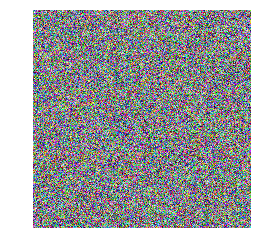

In [711]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_image = np.random.random((256,256,3))
# plt.imshow(noise_image)

preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

noise_image = Image.fromarray(np.uint8(noise_image * 255)).convert('RGB')
inputVar =  Variable(preprocessFn(noise_image).unsqueeze(0).cuda(), requires_grad=True)
inputVar.grad = Variable(torch.randn(1,3,224,224).cuda())

imshow(inputVar.data)

In [629]:
test = inputVar.grad.data.clone()

In [582]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.layer1 = model.features[0]
        self.layer2 = model.features[1]
        self.layer3 = model.features[2]
        self.layer4 = model.features[3]
        self.layer5 = model.features[4]
        self.layer6 = model.features[5]
        self.layer7 = model.features[6]
        self.layer8 = model.features[7]
        self.layer9 = model.features[8]
        self.layer10 = model.features[9]
        self.layer11 = model.features[10]
        self.layer12 = model.features[11]
        self.layer13 = model.features[12]
        self.layer14 = model.features[13]
        self.layer15 = model.features[14]
        self.layer16 = model.features[15]
        self.layer17 = model.features[16]
        self.layer18 = model.features[17]
        self.layer19 = model.features[18]
        self.layer20 = model.features[19]

    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        out = self.layer17(out)
        out = self.layer18(out)
        out = self.layer19(out)
        out = self.layer20(out)

        return out

In [717]:
import time

my_model = MyNetwork().cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
optimizer = torch.optim.LBFGS(inputVar.data)
criterion = nn.MSELoss().cuda()
loss_list = []

t0 = time.time()

for i in range(0,500):
    
    current_input = my_model(inputVar)

    # the mean squared difference between Fl and Pl is computed to give the content loss Lcontent (right)
    loss = criterion(current_input, target_activations)
    loss_list.append(loss.data[0])
#     optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
tn = time.time()
print(tn - t0)

TypeError: params argument given to the optimizer should be an iterable of Variables or dicts, but got torch.cuda.FloatTensor

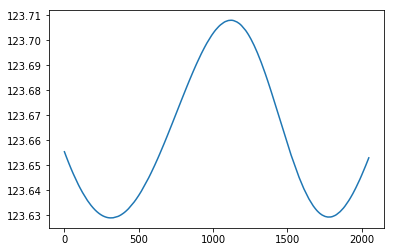

In [710]:
plt.plot(loss_list)

In [636]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    # convert torch tensor to PIL image and then show image inline.
    img = transforms.ToPILImage()(img[0].cpu() * 0.5 + 0.5) # denormalize tensor before convert
    plt.imshow(img, aspect = None)
    plt.axis('off')
    plt.gcf().set_size_inches(4, 4)
    plt.show()

# target = torch.load(open('layer-19-output.p'))
# print(target.size())
'''torch.Size([1, 512, 28, 28])'''

# Your solution goes here. Show the reconstructed input and tell us who is depicted in the incognito.jpg image.

'torch.Size([1, 512, 28, 28])'

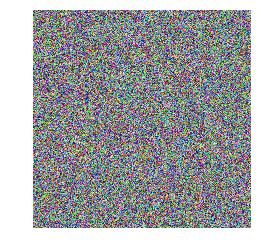

In [637]:
imshow(inputVar.data)

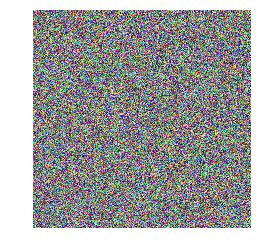

In [701]:
imshow(inputVar.grad.data)

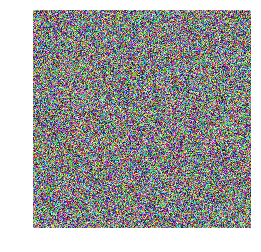

In [634]:
imshow(test)

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>